# Final Project Capstone
## Neighborhoods Battle

### Problem

This notebook finds compare, understand and analyze the data between Toronto neighborhoods.
The problem to solve is find which of these neighborhoods is more similar to where hypothetically I'm currently living.
As reminder, the main problem is the next:

> I'm currently living in the West side of the city of Toronto in Canada. I love where I live because all the amenities that the place offers, such as restaurants, hospitals, etc. The problem start when I recive a great job offer, but to take it, I must move to another neighborhood. So, with Machine Learning techniques, and EDA, I wanna find the place more similar to my current neighborhood.

**Problem details:**
- I'm living in West Toronto Borough, specifically in Dufferin, Dovercourt Village
- I got a job offer in Rouge Hill, Port Union, Highland Creek, Scarborough

Which neighbourhood have the 'optimal' integration between distance to the job location and similarity of amenities in relation with my actual neighbourhood? 

### Dataset
We already have the basic dataset [**neighborhood-toronto-location**](https://github.com/ftarantuviez/data_science_capstone/blob/master/neighborhood-toronto-location.csv). This dataset contains just five **features**:
   - postal_code (dtype: string, length: 3), which represents the postal code of the neighborhood
   - borough (dtype: string), which tell us the borough where the neighborhood belongs
   - neighborhood (dtype: string), that is the name of the neighborhood
   - latitude (dtype: float), this is the coordinate of latitude where the neighborhood is
   - longitude (dtype: float), this is the coordinate of longitude where the neighborhood is
       
Useful facts to consider:
       
- The dataset is already cleaned (no NaN values)
- The features *postal_code*, *borough* and *neighborhood* were extracted from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
- In base of the previous features, *latitude* and *longitude* were matched with the geolocator Nominatim from geopy package

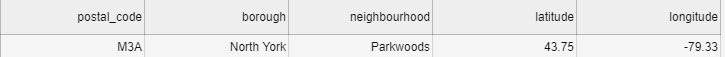

## Objectives

In this notebook we will:
- Understand the data we already have, use data visualization to achive it
- Use Forsquare API to get useful data of the amenities in the neighborhoods
- Extract some new features applying Feature Engineering techniques
- Apply clustering algorithms with the objective of compare and make conclusions

In [1]:
# Handle data
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium # Geospacial visuzalization

# API REST utils
import requests
import json

# Machine Learning techniques and useful transformers
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# To handle enviroments
from dotenv import load_dotenv
import os
load_dotenv()

True

## Load dataset

The basic dataset it's found in [github](https://github.com/ftarantuviez/data_science_capstone/blob/master/neighborhood-toronto-location.csv)

In [2]:
main_df = pd.read_csv("../ETL_notebooks/datasets/toronto-location.csv")
main_df.head()

,postal_code,borough,neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.75,-79.33
1,M4A,North York,Victoria Village,43.73,-79.31
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.66,-79.36
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72,-79.45
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66,-79.39


## Define useful variables

Here we define useful variables that can be used repetedly in a future

In [3]:
# foursquare API REST
FOURSQUARE_CLIENT_ID = os.environ["CLIENT_ID"]
FOURSQUARE_CLIENT_SECRET = os.environ["CLIENT_SECRET"]
FOURSQUARE_VERSION = os.environ["API_VERSION"]

# utils
toronto_latitude = 43.65
toronto_longitude = -79.38
toronto_location = [toronto_latitude, toronto_longitude]
actual_neighbourhood = "Dufferin, Dovercourt Village"
actual_neighbourhood_latitude = 43.67
actual_neighbourhood_longitude = -79.44
actual_neighbourhood_location = [actual_neighbourhood_latitude, actual_neighbourhood_longitude]
job_neighbourhood = "Cedarbrae"
job_borough = "Scarborough"

### Agrouping neighborhoods

Let's watch the neighborhoods according the borough they belong

Text(0, 0.5, 'Quantity of Neighborhoods')

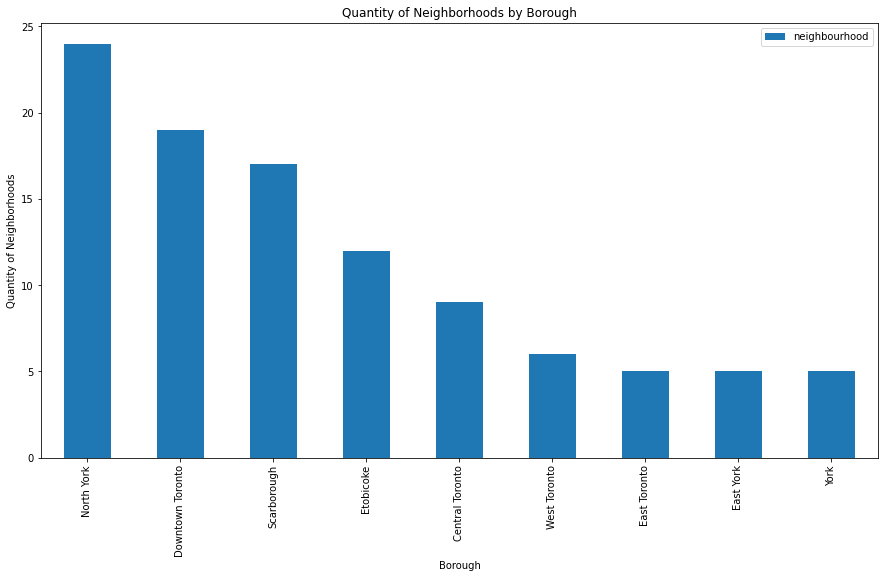

In [4]:
neighbourhoods_by_borough = main_df[["neighbourhood", "borough"]].groupby(["borough"]).count().sort_values(by="neighbourhood", ascending=False)
neighbourhoods_by_borough.reset_index().plot(kind="bar", x="borough", y="neighbourhood", figsize=(15, 8))
plt.title("Quantity of Neighborhoods by Borough")
plt.xlabel("Borough")
plt.ylabel("Quantity of Neighborhoods")

## Visualizing neighbourhoods

To understand better where we are living, and where it's the job offer location, let's draw a map which tell us about it.
For better understanding, we differeciate by four colors:
1. **Red**: our actual neighbourhood
2. **Green**: the job neighbourhood
3. **Orange**: the job borough (this can tell us which neighbourhoods are closer to the job*)
4. **Blue**: that depicts all the others neighbourhoods

As reminder, we don't just look for the closest neighbourhood in relation to the job location (that would be easy :p). We are looking for two principal factors:
- Good distance between the neighbourhood and the job
- Similarity between our current neighbourhood and the future one

In [5]:
toronto_map = folium.Map(location=toronto_location, zoom_start=10)

def return_custom_color(neighbourhood, borough):
    if neighbourhood == actual_neighbourhood:
        return "red", "#f75555"
    if neighbourhood == job_neighbourhood:
        return "green", "#82e282"
    if borough == job_borough:
        return "orange", "#f9cc79"
    else:
        return "blue", "#3186cc"

for latitude, longitude, neighbourhood, borough in zip(main_df["latitude"], main_df["longitude"], main_df["neighbourhood"], main_df["borough"]):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True) 
    color, fill_color = return_custom_color(neighbourhood, borough)
    
    folium.CircleMarker(
        [latitude, longitude],
        popup=label,
        radius=6,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(toronto_map)
toronto_map

## Analyzing the Map

Let's understand key information that the map give to us:

- **First**: Our neighbourhood (in red) is very far to the job neighbourhood.
- **Second**: weird values. If we look closer to the yellow circles (Scarborough) we notice that in the middle there is one blue circle that does not make much sense.

Before to handle the second point, let's watch if there are more values like that:

In [6]:
colors_circles = pd.DataFrame(
[{"color_border": "#242038", "color_fill": "#725AC1"}, 
{"color_border": "#3A445D", "color_fill": "#5E5768"},
{"color_border": "#4E0250", "color_fill": "#801A86"}, 
{"color_border": "#58BC82", "color_fill": "#8FE388"},
{"color_border": "#4C4C9D", "color_fill": "#48639C"},
{"color_border": "#4E6E5D", "color_fill": "#4DA167"},
{"color_border": "#63768D", "color_fill": "#8AC6D0"},
{"color_border": "#63372C", "color_fill": "#C97D60"},
{"color_border": "#586994", "color_fill": "#7D869C"}]
)
boroughs = pd.DataFrame(main_df["borough"].unique(), columns=["borough"])
boroughs_colors = pd.concat([boroughs, colors_circles], axis=1)

def return_color_by_borough(borough):
    return boroughs_colors[boroughs_colors["borough"] == borough]

In [7]:
toronto_map_by_borough = folium.Map(location=toronto_location, zoom_start=10)
for latitude, longitude, neighbourhood, borough in zip(main_df["latitude"], main_df["longitude"], main_df["neighbourhood"], main_df["borough"]):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True) 
    color, fill_color = return_color_by_borough(borough).values[0,1:]
    
    folium.CircleMarker(
        [latitude, longitude],
        popup=label,
        radius=6,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(toronto_map_by_borough)
toronto_map_by_borough

### Handling wrong values
If we look in the above map, we can notice that the only "weird" value is the previous that we mentioned. Then, let's handle it!

How? Well, is just one value, so we are going to google it! (the value is "Business reply mail Processing Centre, South Central Letter Processing Plant Toronto")

What did we find? That this value is not even a neighbourhood, but a Processing Center
So, let's remove it from our dataset!

In [8]:
main_df.drop(main_df[main_df["neighbourhood"] == "Business reply mail Processing Centre, South Central Letter Processing Plant Toronto"].index[0], inplace=True)

In [9]:
toronto_map = folium.Map(location=toronto_location, zoom_start=11)
for latitude, longitude, neighbourhood, borough in zip(main_df["latitude"], main_df["longitude"], main_df["neighbourhood"], main_df["borough"]):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True) 
    color, fill_color = return_custom_color(neighbourhood, borough)
    
    folium.CircleMarker(
        [latitude, longitude],
        popup=label,
        radius=6,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(toronto_map)
toronto_map

## Start extracting venues data

We will use the [Foursquare API](https://foursquare.com/) to extract data of the venues near to each neighbourhood

Let's start wacthing the venues near to our neighbourhood

In [10]:
radius = 500
limit = 100
actual_neighbourhood_venues_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    FOURSQUARE_CLIENT_ID, 
    FOURSQUARE_CLIENT_SECRET, 
    FOURSQUARE_VERSION, 
    actual_neighbourhood_latitude, 
    actual_neighbourhood_longitude, 
    radius, 
    limit)

In [11]:
actual_neighbourhood_venues = requests.get(actual_neighbourhood_venues_url).json()

### Get venue data

This function help us to extract the useful data from the json request

It returns an object with the keys:
- ven_id: the identifier value of the venue
- ven_name: the actual name of the venue
- ven_address: the name of the street and the number
- ven_lat: venue latitude
- ven_lng: venue longitude
- ven_category_id: identifier value of the venue category
- ven_category_name: category name of the venue

In [12]:
def get_venue_data(venue):
    ven_id = venue["id"]
    ven_name = venue["name"]
    ven_address = venue["location"]["formattedAddress"][0]
    ven_lat = venue["location"]["lat"]
    ven_lng = venue["location"]["lng"]
    ven_category_id = venue["categories"][0]["id"]
    ven_category_name = venue["categories"][0]["name"]
    
    return {"ven_id": ven_id, 
            "ven_name": ven_name, 
            "ven_lat": ven_lat, 
            "ven_lng": ven_lng, 
            "ven_category_name": ven_category_name,
            "ven_category_id": ven_category_id,
            "ven_address": ven_address, 
           }

In [13]:
venues = []
for venue in actual_neighbourhood_venues["response"]["groups"][0]["items"]:
    venues.append(get_venue_data(venue["venue"]))

In [14]:
pd.DataFrame(venues).head(2)

,ven_id,ven_name,ven_lat,ven_lng,ven_category_name,ven_category_id,ven_address
0,5753753b498eeb535c53aed5,The Greater Good Bar,43.669409,-79.439267,Bar,4bf58dd8d48988d116941735,229 Geary St (at Dufferin St)
1,5a5659ab17556229a036b74a,Parallel,43.669516,-79.438728,Middle Eastern Restaurant,4bf58dd8d48988d115941735,217 Geary Ave.


### Now get all the venues

So, let's get all the venues from all the Toronto neighbourhoods

In [15]:
def get_venues_by_neighbourhood(names, latitudes, longitudes, borough):
    venues_data = []
    for name, lat, lng, borough in zip(names, latitudes, longitudes, borough):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        req = requests.get(url).json()
        items = req["response"]["groups"][0]["items"]
        
        for venue in items:
            new_venue = get_venue_data(venue["venue"])
            new_venue["neighbourhood"] = name
            new_venue["neighbourhood_lat"] = lat
            new_venue["neigbourhood_long"] = lng
            new_venue["borough"] = borough
            
            venues_data.append(new_venue)
        
    return pd.DataFrame(venues_data)

In [16]:
neigh_venues_df = get_venues_by_neighbourhood(
                    main_df["neighbourhood"],
                    main_df["latitude"],
                    main_df["longitude"],
                    main_df["borough"])

In [17]:
neigh_venues_df.head(5)

,ven_id,ven_name,ven_lat,ven_lng,ven_category_name,ven_category_id,ven_address,neighbourhood,neighbourhood_lat,neigbourhood_long,borough
0,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park,4bf58dd8d48988d163941735,Toronto,Parkwoods,43.75,-79.33,North York
1,4e13a489b0fb5dfdd0756c90,PetSmart,43.748639,-79.333488,Pet Store,4bf58dd8d48988d100951735,Ontario,Parkwoods,43.75,-79.33,North York
2,4cb11e2075ebb60cd1c4caad,Variety Store,43.751974,-79.333114,Food & Drink Shop,4bf58dd8d48988d1f9941735,29 Valley Woods Road,Parkwoods,43.75,-79.33,North York
3,4aec8a50f964a5207ac821e3,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant,4bf58dd8d48988d115941735,1646 Victoria Park Ave,Victoria Village,43.73,-79.31,North York
4,4bb653b9941ad13a7c401fe3,Wigmore Park,43.731023,-79.310771,Park,4bf58dd8d48988d163941735,Toronto ON,Victoria Village,43.73,-79.31,North York


# We are done!

We already have the data that we wanted from this notebook! So, let's persist the dataset into a csv file called **"toronto-venues.csv"**

In [18]:
neigh_venues_df.to_csv("datasets/toronto-venues.csv", index=False)